In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer

## Import data

In [14]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
train.drop(columns=['id', 'Sex'], axis=1, inplace=True)

## Visualize feature distribution

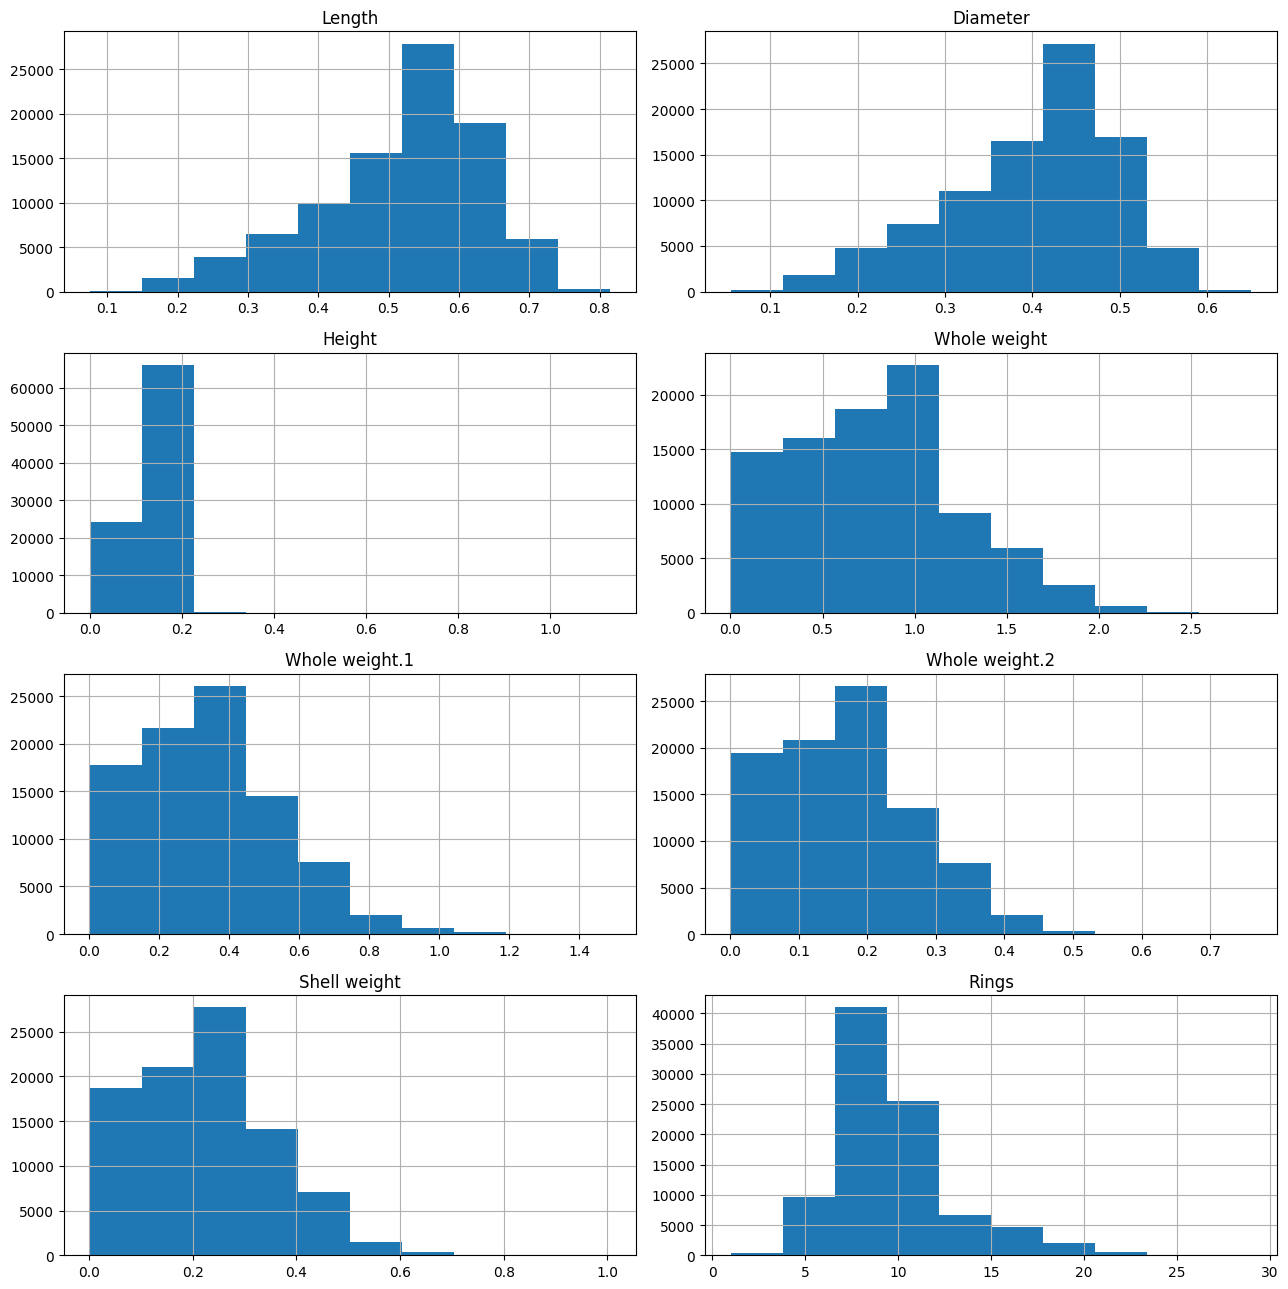

In [15]:
# Calculate the number of rows and columns for subplots
feat_count = len(train.columns)
rows = math.ceil(feat_count / 2)  # Calculate the number of rows
cols = 2  # Fixed number of columns (2 per row)

# Create subplots
fig, ax = plt.subplots(rows, cols, figsize=(13, 13))

# Flatten the axes array for easier iteration
ax = ax.flatten()

# Enumerate over columns and plot histograms
for i, column in enumerate(train.columns):
    ax[i].hist(train[column])
    ax[i].set_title(column)
    ax[i].grid()

# Hide empty subplots if feat_count is odd
if feat_count % 2 != 0:
    ax[-1].axis('off')

plt.tight_layout()

plt.show()

### When our data distribution is skewed, we can apply scalers and other transformerations to try and normalize the data. We test the effects of different scalers on some ML models

## Class for testing scalers

100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


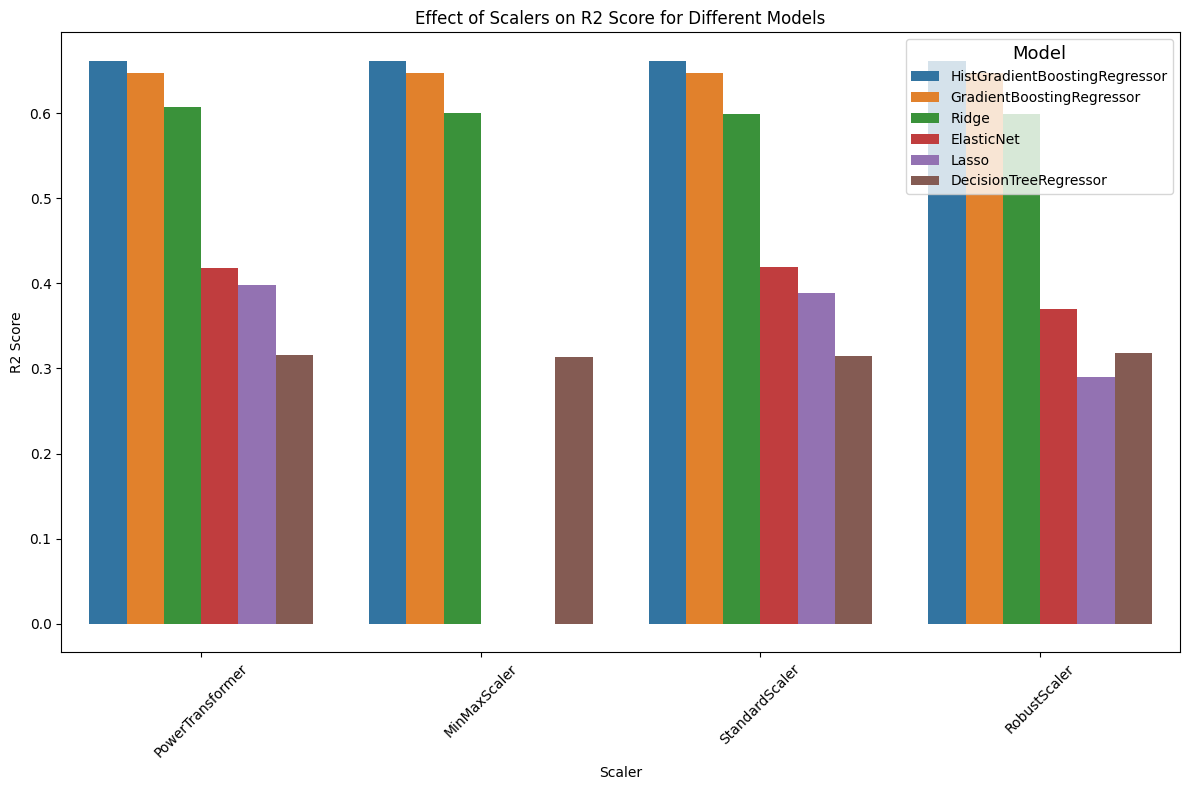

Top 5 Results:
1. Model: HistGradientBoostingRegressor, Scaler: PowerTransformer, R2 Score: 0.6617
2. Model: HistGradientBoostingRegressor, Scaler: MinMaxScaler, R2 Score: 0.6616
3. Model: HistGradientBoostingRegressor, Scaler: StandardScaler, R2 Score: 0.6611
4. Model: HistGradientBoostingRegressor, Scaler: RobustScaler, R2 Score: 0.6608
5. Model: GradientBoostingRegressor, Scaler: MinMaxScaler, R2 Score: 0.6475


In [19]:
class ScalerTesting:
    
    def __init__(self, model, scaler, df):
        self.model = model
        self.scaler = scaler
        self.df = df
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        self.results = None
    
    def split(self):
        X = self.df.drop(columns=['Rings'], axis=1)
        y = self.df['Rings']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=24)
        self.X_train_scaled, self.X_test_scaled, _, _ = self.scale()
    
    def scale(self):
        scaler = self.scaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)
        return X_train_scaled, X_test_scaled, self.y_train, self.y_test

    def fit(self):
        model = self.model()
        model.fit(self.X_train_scaled, self.y_train)
        predictions = model.predict(self.X_test_scaled)
        R2_score = model.score(self.X_test_scaled, self.y_test)
        MSE = mean_squared_error(self.y_test, predictions)
        return {'R2_score': R2_score, 'Mean Squared Error': MSE}

    def run_grid_search(self, param_grid):
        total_combinations = len(param_grid['model']) * len(param_grid['scaler'])
        self.results = []

        with tqdm(total=total_combinations) as pbar:
            for model_class, scaler_class, df in product(param_grid['model'], param_grid['scaler'], [param_grid['df']]):
                model_name = model_class.__name__
                scaler_name = scaler_class.__name__

                scaler_tester = ScalerTesting(model=model_class, scaler=scaler_class, df=df)
                scaler_tester.split()
                scores = scaler_tester.fit()

                result = {'model': model_name, 'scaler': scaler_name, 'scores': scores}
                self.results.append(result)

                pbar.update(1)

    def plot_results(self):
        sorted_results = sorted(self.results, key=lambda x: x['scores']['R2_score'], reverse=True)
        sorted_results_df = pd.DataFrame(sorted_results)
        sorted_results_df['R2_score'] = sorted_results_df['scores'].apply(lambda x: x['R2_score'])

        plt.figure(figsize=(12, 8))
        sns.barplot(data=sorted_results_df, x='scaler', y='R2_score', hue='model')

        plt.xlabel('Scaler')
        plt.ylabel('R2 Score')
        plt.title('Effect of Scalers on R2 Score for Different Models')

        plt.xticks(rotation=45)
        plt.legend(title='Model', title_fontsize='13')

        plt.tight_layout()
        plt.show()

        # Print results
        print("Top 5 Results:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"{i}. Model: {result['model']}, Scaler: {result['scaler']}, "
                  f"R2 Score: {result['scores']['R2_score']:.4f}")
        
if __name__ == '__main__':
    param_grid = {
        'model': [HistGradientBoostingRegressor, DecisionTreeRegressor, 
                  GradientBoostingRegressor, ElasticNet, Ridge, Lasso],
        'scaler': [MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer],
        'df': train
    }

    tester = ScalerTesting(None, None, None)  # Initialize with placeholders
    tester.run_grid_search(param_grid)
    tester.plot_results()